### Import Libraries

In [9]:
import os
import math
import time
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.datasets import MovieLens
from torch_geometric.data import Data
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import softmax

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

print("Loading MovieLens...")
# Download MovieLens (Small)
dataset = MovieLens(root='./data/ml-latest-small')
data = dataset[0]

Using device: cpu
Loading MovieLens...


Extracting data/ml-latest-small/raw/ml-latest-small.zip
Processing...
/opt/homebrew/Caskroom/miniconda/base/envs/cs224w_hw/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniconda/base/envs/cs224w_hw/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <367D4265-B20F-34BD-94EB-4F3EE47C385B> /opt/homebrew/Caskroom/miniconda/base/envs/cs224w_hw/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniconda/base/envs/cs224w_hw/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniconda/base/envs/cs224w_hw/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniconda/base/envs/cs224w_hw/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/minicond

### Config

In [10]:
# ==========================================
# CONFIGURATION & HYPERPARAMETERS
# ==========================================
class Config:
    # Dataset
    data_path = './data/ml-latest-small/raw/ml-latest-small/ratings.csv'
    
    # Model Architecture
    node_emb_dim = 64
    time_emb_dim = 64
    hidden_dim = 64
    n_layers = 2
    n_heads = 2
    dropout = 0.1
    
    # Neighbor Sampling
    num_neighbors = 20  # Sample k recent neighbors
    
    # Training
    batch_size = 200
    epochs = 10
    lr = 0.0001
    weight_decay = 1e-5
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config()
print(f"Using device: {config.device}")

Using device: cpu


In [11]:
# ==========================================
# Data Loading & Temporal Split
# ==========================================
def load_temporal_data(path):
    print("Loading data...")
    # Load ratings with timestamp
    df = pd.read_csv(path)
    
    # Remap IDs to continuous range [0, N)
    # Users: 0 to num_users - 1
    # Items: num_users to num_users + num_items - 1
    user_ids, users = pd.factorize(df['userId'])
    item_ids, items = pd.factorize(df['movieId'])
    
    num_users = len(users)
    num_items = len(items)
    num_nodes = num_users + num_items
    
    # Adjust item IDs
    df['user_idx'] = user_ids
    df['item_idx'] = item_ids + num_users
    df['timestamp'] = df['timestamp'].astype(float)
    
    # Sort by time for temporal splitting
    df = df.sort_values('timestamp').reset_index(drop=True)
    
    # Normalize timestamps
    ts = df['timestamp'].values
    ts = (ts - ts.min())
    ts = ts / 10.0 
    df['timestamp'] = ts
    
    # Extract edges: src, dst, time
    src = df['user_idx'].values
    dst = df['item_idx'].values
    times = df['timestamp'].values
    
    # Split: 80% Train, 10% Val, 10% Test (Chronological)
    n_total = len(df)
    n_train = int(n_total * 0.8)
    n_test = n_total - n_train
    
    train_data = {
        'src': src[:n_train],
        'dst': dst[:n_train],
        'time': times[:n_train]
    }
    
    test_data = {
        'src': src[n_train:],
        'dst': dst[n_train:],
        'time': times[n_train:]
    }
    
    print(f"Total Interactions: {n_total}")
    print(f"Train: {n_train}, Test: {n_test}")
    print(f"Num Users: {num_users}, Num Items: {num_items}, Total Nodes: {num_nodes}")
    
    return train_data, test_data, num_nodes, num_users, num_items

train_data, test_data, num_nodes, num_users, num_items = load_temporal_data(config.data_path)

# ==========================================
# Neighbour Finder (Temporal Sampling)
# ==========================================
class NeighborFinder:
    def __init__(self, adj_list, uniform=False):
        """
        adj_list: List of lists, where adj_list[node] = [(neighbor, timestamp, edge_idx), ...]
        We assume the inner lists are SORTED by timestamp.
        """
        self.adj_list = adj_list
        self.uniform = uniform # If True, sample uniformly; else sample most recent
        
    def get_temporal_neighbors(self, source_nodes, timestamps, n_neighbors=20):
        """
        Find neighbors for source_nodes that interacted BEFORE the given timestamps.
        """
        assert len(source_nodes) == len(timestamps)
        
        tmp_n_neighbors = n_neighbors if n_neighbors > 0 else 1
        
        # Placeholders
        # Shape: [batch_size, n_neighbors]
        neighbors = np.zeros((len(source_nodes), tmp_n_neighbors), dtype=np.int32)
        edge_times = np.zeros((len(source_nodes), tmp_n_neighbors), dtype=np.float32)
        mask = np.zeros((len(source_nodes), tmp_n_neighbors), dtype=bool) # 1 if real neighbor, 0 if padding
        
        for i, (node, t) in enumerate(zip(source_nodes, timestamps)):
            node_edges = self.adj_list[node]
            
            # Filter edges < t
            valid_edges = []
            
            # Reverse iterate to find recent neighbors first
            for j in range(len(node_edges) - 1, -1, -1):
                nbr, edge_t = node_edges[j]
                if edge_t < t:
                    valid_edges.append((nbr, edge_t))
                    if len(valid_edges) >= n_neighbors:
                        break
            
            # If no neighbors
            if len(valid_edges) == 0:
                continue # mask remains 0
            
            # Pack into arrays
            for j, (nbr, edge_t) in enumerate(valid_edges):
                neighbors[i, j] = nbr
                edge_times[i, j] = edge_t
                mask[i, j] = 1
                
        return neighbors, edge_times, mask

def init_neighbor_finder(data_src, data_dst, data_time, num_nodes):
    """Build adjacency list from training data"""
    adj_list = [[] for _ in range(num_nodes)]
    
    for s, d, t in zip(data_src, data_dst, data_time):
        # Add undirected edges for aggregation context
        adj_list[s].append((d, t))
        adj_list[d].append((s, t))
        
    # Sort by time for efficient querying
    for i in range(num_nodes):
        adj_list[i].sort(key=lambda x: x[1])
        
    return NeighborFinder(adj_list)

# Initialize finder with ALL training data
train_ngh_finder = init_neighbor_finder(train_data['src'], train_data['dst'], train_data['time'], num_nodes)

# ==========================================
# Model Components
# ==========================================
class TimeEncode(nn.Module):
    """
    Functional Time Encoding based on Bochner's Theorem.
    Phi(t) = sqrt(1/d) * [cos(w_1 t), sin(w_1 t), ..., cos(w_d t), sin(w_d t)]
    """
    def __init__(self, dim):
        super(TimeEncode, self).__init__()
        self.dim = dim
        # Learnable frequencies w
        self.w = nn.Linear(1, dim, bias=False)
        self.w.weight.data = torch.randn(dim, 1) # Initialize frequencies
        
    def forward(self, t):
        # t: [batch_size] -> [batch_size, 1]
        t = t.unsqueeze(1)
        output = torch.cos(self.w(t))
        # Ensure dimensionality matches
        return output

class MergeLayer(nn.Module):
    """
    FFN to merge aggregated features with target node features.
    """
    def __init__(self, dim1, dim2, dim3, dim4):
        super(MergeLayer, self).__init__()
        self.fc1 = nn.Linear(dim1 + dim2, dim3)
        self.fc2 = nn.Linear(dim3, dim4)
        self.act = nn.ReLU()
        
    def forward(self, x1, x2):
        x = torch.cat([x1, x2], dim=1)
        h = self.act(self.fc1(x))
        return self.fc2(h)

class TGATLayer(nn.Module):
    """
    Single TGAT Layer with Multi-Head Attention
    """
    def __init__(self, n_node_features, n_time_features, n_output_features, n_heads=2, dropout=0.1):
        super(TGATLayer, self).__init__()
        self.n_heads = n_heads
        self.n_output_features = n_output_features
        
        # Dimensions per head
        self.head_dim = n_output_features // n_heads
        
        # Projections for Q, K, V
        # Input to Q: [node_features + time_features(0)]
        # Input to K, V: [neighbor_features + time_features(delta_t)]
        self.W_q = nn.Linear(n_node_features + n_time_features, n_output_features)
        self.W_k = nn.Linear(n_node_features + n_time_features, n_output_features)
        self.W_v = nn.Linear(n_node_features + n_time_features, n_output_features)
        
        # Final aggregation FFN
        self.merge = MergeLayer(n_output_features, n_node_features, n_output_features, n_output_features)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src_node_features, src_time_features, neighbors_features, 
                neighbors_time_features, neighbors_padding_mask):
        """
        src_node_features: [batch, feat_dim]
        src_time_features: [batch, time_dim] (Encoding of 0)
        neighbors_features: [batch, n_neighbors, feat_dim]
        neighbors_time_features: [batch, n_neighbors, time_dim] (Encoding of t - t_nbr)
        neighbors_padding_mask: [batch, n_neighbors] (0 for padding)
        """
        batch_size = src_node_features.size(0)
        
        # 1. Prepare Inputs for Attention
        # Query: Src node + Zero time encoding
        query_input = torch.cat([src_node_features, src_time_features], dim=1)
        Q = self.W_q(query_input).view(batch_size, self.n_heads, self.head_dim)
        
        # key/value: neighbors + relative time encoding
        keys_input = torch.cat([neighbors_features, neighbors_time_features], dim=2)
        K = self.W_k(keys_input).view(batch_size, -1, self.n_heads, self.head_dim)
        V = self.W_v(keys_input).view(batch_size, -1, self.n_heads, self.head_dim)
        
        # calculate attention scores
        Q = Q.unsqueeze(1) 
        attn_scores = torch.sum(Q * K, dim=3)
        attn_scores = attn_scores / math.sqrt(self.head_dim)
        
        # mask padding
        mask_expanded = neighbors_padding_mask.unsqueeze(2).expand_as(attn_scores)
        attn_scores = attn_scores.masked_fill(mask_expanded == 0, -1e9)
        
        attn_weights = F.softmax(attn_scores, dim=1)
        attn_weights = self.dropout(attn_weights)
        
        # aggregate values
        weighted_V = V * attn_weights.unsqueeze(3)
        agg_features = torch.sum(weighted_V, dim=1)
        
        # concat heads
        agg_features = agg_features.view(batch_size, self.n_output_features)
        
        # merge with source features
        output = self.merge(agg_features, src_node_features)
        
        return output

class TGAT(nn.Module):
    def __init__(self, ngh_finder, num_nodes, node_emb_dim, time_emb_dim, hidden_dim, 
                 n_layers=2, n_heads=2, dropout=0.1):
        super(TGAT, self).__init__()
        self.ngh_finder = ngh_finder
        self.time_emb_dim = time_emb_dim
        
        self.node_embedding = nn.Embedding(num_nodes, node_emb_dim)
        nn.init.xavier_uniform_(self.node_embedding.weight)
        self.time_encoder = TimeEncode(time_emb_dim)
        
        self.layers = nn.ModuleList()
        self.layers.append(TGATLayer(node_emb_dim, time_emb_dim, hidden_dim, n_heads, dropout))
        for _ in range(n_layers - 1):
            self.layers.append(TGATLayer(hidden_dim, time_emb_dim, hidden_dim, n_heads, dropout))
            
    def compute_embedding(self, nodes, timestamps, n_layers=2):
        """
        Inductively compute embeddings for 'nodes' at 'timestamps' by aggregating history.
        """
        # Ensure inputs are tensors on device
        nodes = torch.from_numpy(nodes).long().to(config.device) if isinstance(nodes, np.ndarray) else nodes
        timestamps = torch.from_numpy(timestamps).float().to(config.device) if isinstance(timestamps, np.ndarray) else timestamps
        
        batch_size = len(nodes)
        
        # Initial features
        curr_features = self.node_embedding(nodes)
        
        # Get neighbors
        neighbors_arr, edge_times_arr, mask_arr = self.ngh_finder.get_temporal_neighbors(
            nodes.cpu().numpy(), timestamps.cpu().numpy(), n_neighbors=config.num_neighbors
        )
        
        neighbors = torch.from_numpy(neighbors_arr).long().to(config.device)
        edge_times = torch.from_numpy(edge_times_arr).float().to(config.device)
        mask = torch.from_numpy(mask_arr).bool().to(config.device)
        
        # Prepare Neighbor Features (Base embedding)
        neighbor_features = self.node_embedding(neighbors)
        
        # Prepare Time Features
        delta_t = timestamps.unsqueeze(1) - edge_times
        # Flatten to pass through encoder
        delta_t_flat = delta_t.view(-1)
        time_encoding_flat = self.time_encoder(delta_t_flat)
        neighbor_time_features = time_encoding_flat.view(batch_size, config.num_neighbors, self.time_emb_dim)
        
        # Prepare Source Time Features
        zeros = torch.zeros(batch_size).to(config.device)
        src_time_features = self.time_encoder(zeros)
        
        output = curr_features
        for layer in self.layers:
            output = layer(output, src_time_features, neighbor_features, 
                           neighbor_time_features, mask)
            
        return output

# ==========================================
# Training Loop
# ==========================================
def train_epoch(model, train_data, optimizer, batch_size):
    model.train()
    total_loss = 0
    
    # Create batches
    num_samples = len(train_data['src'])
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    
    num_batches = (num_samples + batch_size - 1) // batch_size
    
    for i in range(num_batches):
        batch_idx = indices[i*batch_size : (i+1)*batch_size]
        
        bsrc = train_data['src'][batch_idx]
        bdst = train_data['dst'][batch_idx]
        btime = train_data['time'][batch_idx]
        
        # Negative Sampling
        bneg = np.random.randint(num_users, num_nodes, size=len(batch_idx))
        
        optimizer.zero_grad()
        
        # Compute Embeddings
        
        # Embedding for Source User
        src_embedding = model.compute_embedding(bsrc, btime)
        
        # Embedding for Items (Pos & Neg)
        pos_dst_embedding = model.compute_embedding(bdst, btime)
        neg_dst_embedding = model.compute_embedding(bneg, btime)
        
        # 3. Compute Scores (Dot Product)
        pos_score = (src_embedding * pos_dst_embedding).sum(dim=1)
        neg_score = (src_embedding * neg_dst_embedding).sum(dim=1)
        
        # 4. Loss (BCE with Logits)
        loss = -torch.mean(F.logsigmoid(pos_score) + F.logsigmoid(-neg_score))
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / num_batches

# ==========================================
# Evaluation
# ==========================================
@torch.no_grad()
def evaluate_link_prediction(model, test_data, batch_size=200):
    model.eval()
    
    hr_hit = 0
    ndcg_sum = 0
    total_samples = 0
    
    num_samples = len(test_data['src'])
    
    indices = np.arange(num_samples)
    num_batches = (num_samples + batch_size - 1) // batch_size
    
    for i in range(num_batches):
        batch_idx = indices[i*batch_size : (i+1)*batch_size]
        
        bsrc = test_data['src'][batch_idx]
        bdst = test_data['dst'][batch_idx]
        btime = test_data['time'][batch_idx]
        
        # Compute embeddings for Source and True Item
        src_emb = model.compute_embedding(bsrc, btime)
        pos_dst_emb = model.compute_embedding(bdst, btime)
        
        # Compute scores for positive
        pos_scores = (src_emb * pos_dst_emb).sum(dim=1) # [Batch]
        
        n_neg = 49
        neg_items = np.random.randint(num_users, num_nodes, size=(len(batch_idx), n_neg))
        
        # Flatten negatives to process in batch
        neg_items_flat = neg_items.flatten()
        neg_times_flat = np.repeat(btime, n_neg)
        
        # Compute Negative Embeddings in chunks to avoid OOM
        neg_emb_flat = model.compute_embedding(neg_items_flat, neg_times_flat) 
        neg_emb = neg_emb_flat.view(len(batch_idx), n_neg, -1)
        neg_scores = (src_emb.unsqueeze(1) * neg_emb).sum(dim=2)
        
        all_scores = torch.cat([pos_scores.unsqueeze(1), neg_scores], dim=1)
        
        # Calculate Metrics (Pos is at index 0)
        # Rank: How many scores are > pos_score
        
        # argsort descending
        _, sorted_indices = torch.sort(all_scores, descending=True, dim=1)
        
        # Find where 0 (true item) is located
        hits = (sorted_indices == 0).nonzero(as_tuple=False)
        # hits column indices are the ranks (0-indexed)
        ranks = hits[:, 1]
        
        # HR@10
        hr_hit += (ranks < 10).sum().item()
        
        # NDCG@10
        # 1 / log2(rank + 2)
        # Only for ranks < 10
        mask = ranks < 10
        ndcg_sum += (1.0 / torch.log2(ranks[mask].float() + 2.0)).sum().item()
        
        total_samples += len(batch_idx)
        
    return hr_hit / total_samples, ndcg_sum / total_samples

Loading data...
Total Interactions: 100836
Train: 80668, Test: 20168
Num Users: 610, Num Items: 9724, Total Nodes: 10334


### Training

In [12]:
# ==========================================
# Initialize Model & Training
# ==========================================

# Initialize Model
tgat = TGAT(
    ngh_finder=train_ngh_finder,
    num_nodes=num_nodes,
    node_emb_dim=config.node_emb_dim,
    time_emb_dim=config.time_emb_dim,
    hidden_dim=config.hidden_dim,
    n_layers=config.n_layers,
    n_heads=config.n_heads,
    dropout=config.dropout
).to(config.device)

optimizer = torch.optim.Adam(tgat.parameters(), lr=config.lr, weight_decay=config.weight_decay)

print(f"\nModel Initialized. Training for {config.epochs} epochs...")

loss_history = []
metric_history = []

for epoch in range(config.epochs):
    start_time = time.time()
    loss = train_epoch(tgat, train_data, optimizer, config.batch_size)
    loss_history.append(loss)
    
    print(f"Epoch {epoch+1}/{config.epochs} | Loss: {loss:.4f} | Time: {time.time()-start_time:.2f}s")
    
    # Evaluate every few epochs to save time
    if (epoch + 1) % 2 == 0 or epoch == 0:
        hr, ndcg = evaluate_link_prediction(tgat, test_data, batch_size=50)
        print(f"   >> Test HR@10: {hr:.4f} | NDCG@10: {ndcg:.4f}")
        metric_history.append((hr, ndcg))


Model Initialized. Training for 10 epochs...
Epoch 1/10 | Loss: 0.9074 | Time: 17.09s
   >> Test HR@10: 0.1569 | NDCG@10: 0.0775
Epoch 2/10 | Loss: 0.6357 | Time: 16.97s
   >> Test HR@10: 0.1616 | NDCG@10: 0.0826
Epoch 3/10 | Loss: 0.5866 | Time: 17.18s
Epoch 4/10 | Loss: 0.5604 | Time: 16.72s
   >> Test HR@10: 0.1568 | NDCG@10: 0.0798
Epoch 5/10 | Loss: 0.5365 | Time: 16.82s
Epoch 6/10 | Loss: 0.5257 | Time: 16.96s
   >> Test HR@10: 0.1494 | NDCG@10: 0.0767
Epoch 7/10 | Loss: 0.5152 | Time: 16.77s
Epoch 8/10 | Loss: 0.5047 | Time: 16.84s
   >> Test HR@10: 0.1512 | NDCG@10: 0.0762
Epoch 9/10 | Loss: 0.4991 | Time: 16.82s
Epoch 10/10 | Loss: 0.4952 | Time: 16.88s
   >> Test HR@10: 0.1506 | NDCG@10: 0.0766


### Evaluation

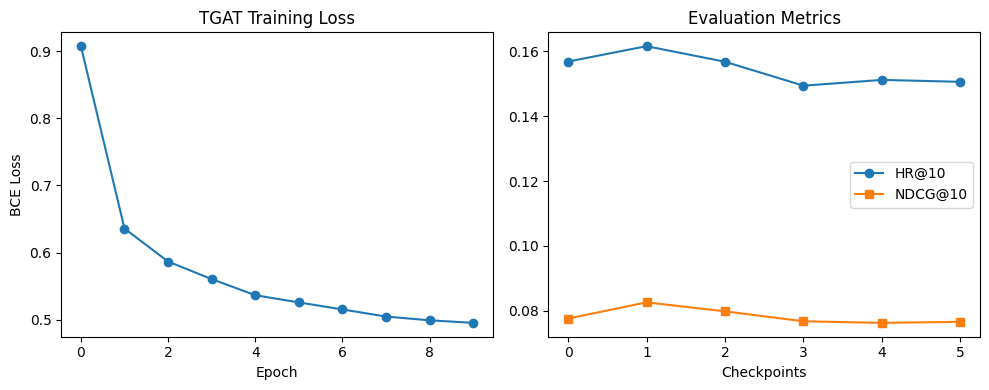


Final Test HR@10: 0.1496
Final Test NDCG@10: 0.0762


In [13]:
# ==========================================
# Visualisation & Evaluation
# ==========================================

# Plotting
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_history, marker='o')
plt.title("TGAT Training Loss")
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")

if metric_history:
    metrics = np.array(metric_history)
    epochs_idx = [i*2 for i in range(len(metrics))] # approx
    plt.subplot(1, 2, 2)
    plt.plot(metrics[:, 0], marker='o', label='HR@10')
    plt.plot(metrics[:, 1], marker='s', label='NDCG@10')
    plt.title("Evaluation Metrics")
    plt.xlabel("Checkpoints")
    plt.legend()

plt.tight_layout()
plt.show()

# Final Metrics
final_hr, final_ndcg = evaluate_link_prediction(tgat, test_data, batch_size=50)
print(f"\nFinal Test HR@10: {final_hr:.4f}")
print(f"Final Test NDCG@10: {final_ndcg:.4f}")